# Machine Learning - Assignment 3

#### Cindy Jeon(section 2, group 7) 

# 1. Data Exploration and Visualization** (15 pts):

- Explore the Melbourne house dataset.
- Provide visualizations such as histograms, scatter plots, or box plots to understand the distribution of different features.
- Include any other plots you find interesting and provide brief interpretations.

In [2]:
# necessary imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew, kstest
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import datasets
import folium
from folium.plugins import HeatMap
from folium import plugins
import plotly.express as px
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Read the datasets
df = pd.read_csv("/Users/daeunjeon/Library/CloudStorage/GoogleDrive-jeond000@gmail.com/My Drive/MSBA UC DAVIS/Winter 2023/ BAX 452_Machine_Learning/HW/HW3/Melbourne_housing.csv")

In [4]:
# Display first six observations
print(df.head(6))

# Check the structure of the data
print(df.info())

# Display the summary of the data
print(df.describe(include='all'))

              Suburb         Address  Rooms Type      Price Method   SellerG  \
0          Thornbury  7/67 Pender St      2    u   438000.0     SP      Love   
1             Coburg      32 Rose St      2    h   901000.0      S     Peter   
2     Bentleigh East  2/25 Brooks St      3    u   800000.0      S  Woodards   
3  Templestowe Lower    2/35 John St      3    t  1155000.0      S    Jellis   
4        South Yarra   1/35 Marne St      3    u  1630000.0     PI    Jellis   
5       Burwood East   14 Kalista Ct      4    h        NaN     PN  Woodards   

         Date  Distance  Postcode  ...  Bathroom  Car  Landsize  BuildingArea  \
0  22/08/2016       6.5      3071  ...       1.0  1.0       0.0          66.0   
1  27/06/2016       7.8      3058  ...       1.0  1.0     545.0         107.0   
2  28/05/2016      13.9      3165  ...       2.0  2.0     261.0           NaN   
3  25/11/2017      12.4      3107  ...       NaN  NaN       NaN           NaN   
4     10/9/16       3.3      3141 

## # Check for missing values

In [5]:
# Count of the missing values of the dataset
missing_values = df.isna().sum()
missing_values

Suburb             0
Address            0
Rooms              0
Type               0
Price            108
Method             0
SellerG            0
Date               0
Distance           0
Postcode           0
Bedroom2         128
Bathroom         128
Car              137
Landsize         174
BuildingArea     310
YearBuilt        287
CouncilArea        0
Lattitude        122
Longtitude       122
Regionname         0
Propertycount      0
dtype: int64

In [6]:
##check the percentage of missing values
cols_to_drop=[]
def display_missing_perc(df):    
    for col in df.columns.tolist():       
        missing_value = 100*(df[col].isnull().sum()/len(df[col]))
        print(f'{col} column missing values: {missing_value}')
        if missing_value >= 40:
            cols_to_drop.append(col)
    print('\n')
display_missing_perc(df)

Suburb column missing values: 0.0
Address column missing values: 0.0
Rooms column missing values: 0.0
Type column missing values: 0.0
Price column missing values: 21.64328657314629
Method column missing values: 0.0
SellerG column missing values: 0.0
Date column missing values: 0.0
Distance column missing values: 0.0
Postcode column missing values: 0.0
Bedroom2 column missing values: 25.651302605210418
Bathroom column missing values: 25.651302605210418
Car column missing values: 27.45490981963928
Landsize column missing values: 34.86973947895792
BuildingArea column missing values: 62.124248496993985
YearBuilt column missing values: 57.51503006012024
CouncilArea column missing values: 0.0
Lattitude column missing values: 24.448897795591183
Longtitude column missing values: 24.448897795591183
Regionname column missing values: 0.0
Propertycount column missing values: 0.0




## *The missing values
- there are missing values for 9 variables
- I will not use the missing values that are more than 40% of its total data which are buildingArea and YearBuilt on my ligression model

## # Cleaning the data_1(unname column, price, car,building area, year built, landsize)

In [7]:
# 1) remove any Unnamed columns 
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# 2) Manage missing values ( 9 variables)

# 2-1) price : drop all of the missing values only in Price(dependent variable)
df = df.dropna(subset=['Price'])

# 2-2) Car : replace missing values as zero
df['Car'] = df['Car'].fillna(0) # for only car variables

# 2-3) buildingArea and YearBuilt : drop due to missing rate is over 40% of its total number of column
df = df.drop(['BuildingArea', 'YearBuilt'], axis=1)

# 2-4) Landsize: fill in median of suburb
# Calculate the median 'Landsize' for each 'Suburb'
median_landsize = df.groupby('Suburb')['Landsize'].median()

#replace na with median of the suburb
df['Landsize'] = df.apply(
    lambda row: median_landsize[row['Suburb']] if pd.isnull(row['Landsize']) else row['Landsize'],
    axis=1
)
# Count of the missing values of the dataset after deleting missing price columns
missing_values = df.isna().sum()
missing_values

Suburb            0
Address           0
Rooms             0
Type              0
Price             0
Method            0
SellerG           0
Date              0
Distance          0
Postcode          0
Bedroom2         92
Bathroom         92
Car               0
Landsize         40
CouncilArea       0
Lattitude        88
Longtitude       88
Regionname        0
Propertycount     0
dtype: int64

## # Exploring data with histogram (after dealing with price, car, buildingArea, YearBuilt, landsize)

In [8]:
# Filtering out non-numeric columns and columns with all null values
numeric_df = df.select_dtypes(include=[np.number])

# Number of numeric variables
num_vars = len(numeric_df.columns)

# Calculate the number of rows and columns for the subplots
n_cols = 4  
n_rows = (num_vars + n_cols - 1) // n_cols  # Ceiling division

# Create a figure with subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over the numeric variables and plot histograms
for ax, var in zip(axes, numeric_df.columns):
    ax.hist(numeric_df[var], bins=50, color='skyblue', edgecolor='black')
    ax.set_title(f'Histogram of {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Frequency')

# Hide any unused axes
for ax in axes[len(numeric_df.columns):]:
    ax.set_visible(False)

# Adjust the layout
plt.tight_layout()
plt.show()

#### - Insight from Histogram (after dealing with price, car,buildingArea, YearBuilt, landsize)

- Based on the histograms, we can find some insight for each variables.
- Rooms : 3 rooms are the most common room style, also 3bedroom and 1 bathroom are the most common
- Cars : 0~2 parking lot is the most common
- Price, Distance, Landsize : they are right skewed distribution which means most of the data fall into left bins. 
- Lattitude and Longtitude : both seems normally distributed

## # Cleaning the data_2 (Imputing)

In [9]:
# 2-3) manage 5 variables with multiple imputation ('Bedroom2', 'Bathroom','Landsize', 'Lattitude', 'Longtitude')
# Selecting the columns for imputation
cols_to_impute = ['Bedroom2', 'Bathroom','Landsize' ,'Lattitude', 'Longtitude'] ##Landsize that was not corrected in the first cleaning will be imputed here 

# Setting up the IterativeImputer
imputer = IterativeImputer()

# Applying the imputer
df[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])

# Converting back to a DataFrame and assigning appropriate column names
df_imputed = pd.DataFrame(df[cols_to_impute], columns=cols_to_impute)

# Count of the missing values of the dataset after deleting missing price columns
missing_values = df.isna().sum()
missing_values


Suburb           0
Address          0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
Bedroom2         0
Bathroom         0
Car              0
Landsize         0
CouncilArea      0
Lattitude        0
Longtitude       0
Regionname       0
Propertycount    0
dtype: int64

## # Exploring data with histogram (after dealing with all missing variables)

In [10]:
# Filtering out non-numeric columns and columns with all null values
numeric_df = df.select_dtypes(include=[np.number])

# Number of numeric variables
num_vars = len(numeric_df.columns)

# Calculate the number of rows and columns for the subplots
n_cols = 4  
n_rows = (num_vars + n_cols - 1) // n_cols  # Ceiling division

# Create a figure with subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over the numeric variables and plot histograms
for ax, var in zip(axes, numeric_df.columns):
    ax.hist(numeric_df[var], bins=50, color='skyblue', edgecolor='black')
    ax.set_title(f'Histogram of {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Frequency')

# Hide any unused axes
for ax in axes[len(numeric_df.columns):]:
    ax.set_visible(False)

# Adjust the layout
plt.tight_layout()
plt.show()

#### - Insight from Histogram (after dealing with all missing variables)

- After dealing with all variables, there are little changes in histogram
- Rooms and Bedrooms2 : Both are rooms but bedroom2 has different source with missing values, so I will not use bedroom2 variable.
- Bathrooms : 1 bathroom is the most, and now there is 1.5 bathrooms due to imputation.
- Latitude, longtitude,landsize : all of sudden, due to the imputation,they have a very distinctive value around its mean. 

## # Exploring subplots to see linear relationship

In [11]:
# Select the numeric columns excluding 'Price'
x_vars_columns = [col for col in numeric_df.columns if col != 'Price']

# Create subsets of x_vars with 4 columns each
subsets_of_x_vars = [x_vars_columns[i:i+4] for i in range(0, len(x_vars_columns), 4)]

# Plot each subset in a separate row
for subset in subsets_of_x_vars:
    sns.pairplot(df, x_vars=subset, y_vars='Price', kind='scatter', height=2.5, aspect=1)
    plt.show()

#### - Insight from subplots

- It seems that there are linear relationships in rooms, distance, postcode, bedroom2, bathroom, car, landsize but it is not very clear

## # Exploring data with lineplot

In [12]:
# Group by Regionname and sum the Prices
grouped_data = df.groupby('Regionname')['Price'].sum().reset_index()

# Sort the data for better visualization
grouped_data = grouped_data.sort_values(by='Price', ascending=False)

# Plotting the data
plt.figure(figsize=(20, 8))
sns.lineplot(data=grouped_data, x='Regionname', y='Price')
plt.title("Sales of Region Names vs Price", fontsize=16)
plt.ylabel('Total Sales Price', fontsize=12)
plt.xlabel('Region Names', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-labels for better readability
plt.show()


#### - Insight from Lineplot of Total sales from 2016 - 2018

- The total sales order from 2016 - 2018 are  Southern > Northern > Western > Eastern > South-Eastern > Eastern victoria > northern victoria > western victoria
- however, it does not mean the average sales price is the same order as the total sales price so let's check the average sales price
- It seems that area play important role for the price of house as we all know

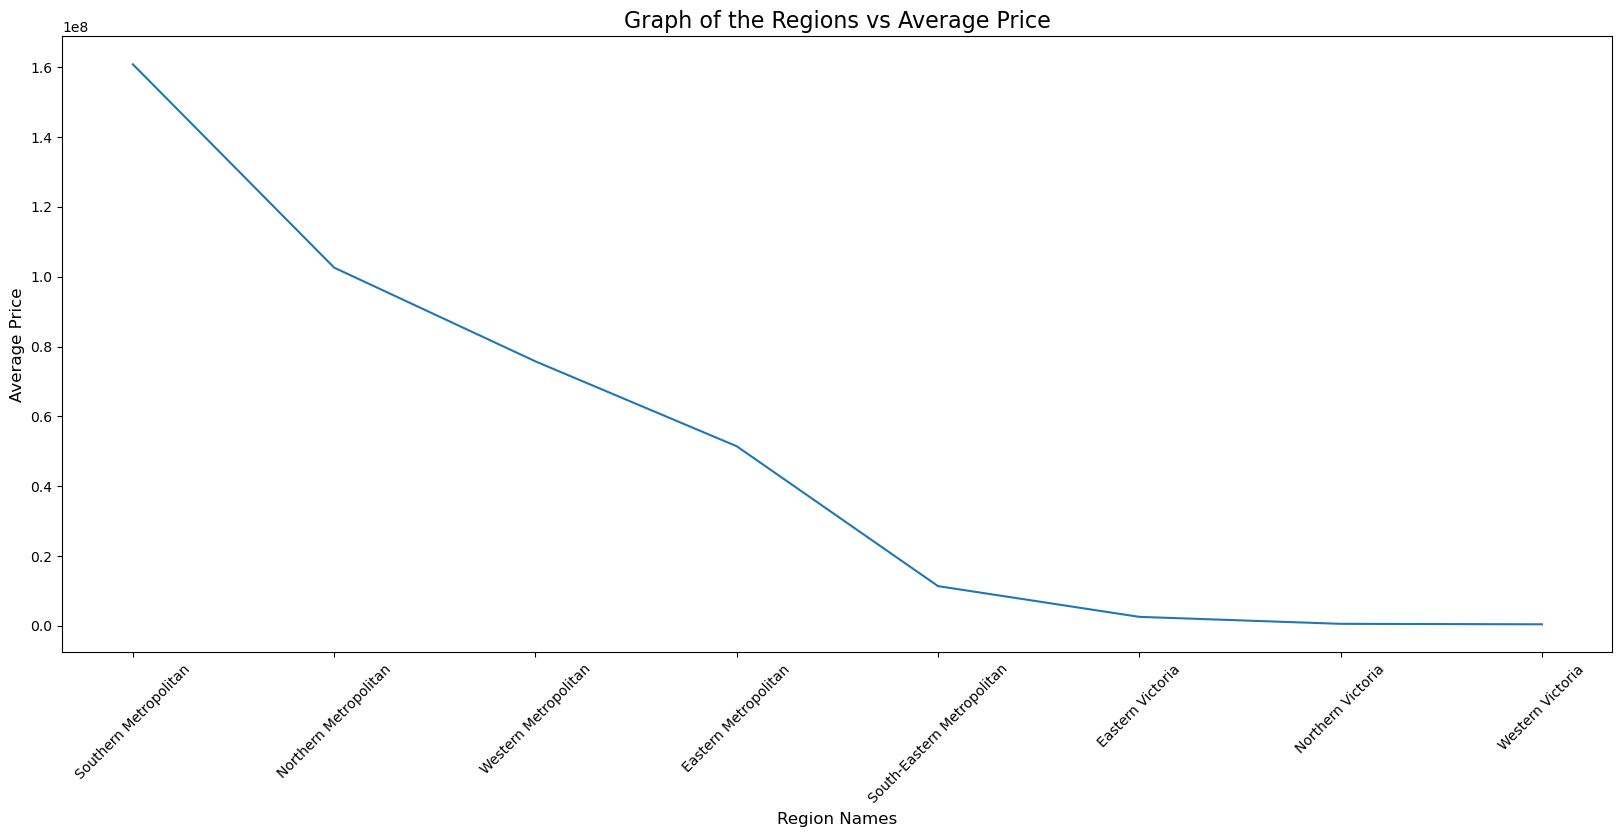

In [13]:
# Sort the data for better visualization
grouped_data = grouped_data.sort_values(by='Price', ascending=False)

# Create a bar plot
plt.figure(figsize=(20, 8))
sns.lineplot(x='Regionname', y='Price', data=grouped_data)

# Setting the title and labels
plt.title("Graph of the Regions vs Average Price", fontsize=16)
plt.ylabel('Average Price', fontsize=12)
plt.xlabel('Region Names', fontsize=12)
plt.xticks(rotation=45)  # Rotating the x-labels for better readability
plt.show()

#### - Insight from Lineplot of the average sales price from 2016 - 2018

- The top 3 area for the average sales price from 2016 - 2018 are  Southern >Eastern > Northern, and although northen area has the second sales amount, their average sales price is 3rd.b

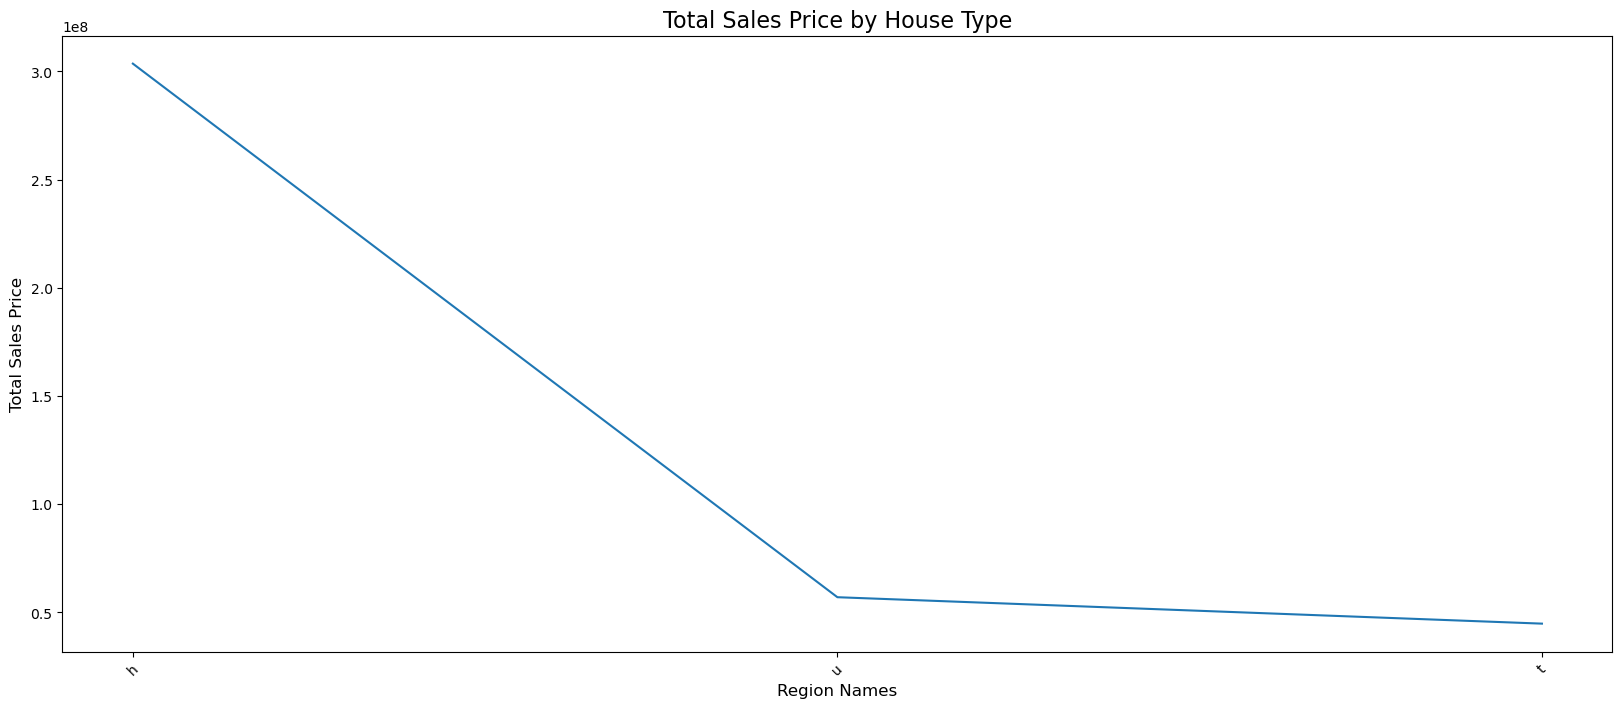

In [14]:
# Group by Regionname and sum the Prices
grouped_data = df.groupby('Type')['Price'].sum().reset_index()

# Sort the data for better visualization
grouped_data = grouped_data.sort_values(by='Price', ascending=False)

# Plotting the data
plt.figure(figsize=(20, 8))
sns.lineplot(data=grouped_data, x='Type', y='Price')
plt.title("Total Sales Price by House Type", fontsize=16)
plt.ylabel('Total Sales Price', fontsize=12)
plt.xlabel('Region Names', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-labels for better readability
plt.show()

#### - Insight from Lineplot of the house type and price

- house,cottage,villa, semi,terrace has much more sales than unit or town house

## # Exploring data with correlation

In [15]:
# Corrleation

numeric_df = df.select_dtypes(include=[np.number])
correlation = sns.heatmap(numeric_df.corr(), vmin=-1, vmax=1, annot=True, linewidths=1, linecolor='black')

#### - Insight of Correlations

- There are not many high correlation except for the similar features, such as bedroom2 and bathroom/rooms

## # check multicolinearity of data

In [16]:
# Assuming 'df' is your DataFrame and it contains only numeric variables
# Filtering out non-numeric columns and columns with all null values
numeric_df = df.select_dtypes(include=[np.number])

# Add a constant term (intercept) to the predictors
X = add_constant(numeric_df)

# Create a DataFrame to hold VIF scores
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

         Variable           VIF
0           const  2.631618e+06
1           Rooms  3.148955e+00
2           Price  1.997939e+00
3        Distance  2.080281e+00
4        Postcode  1.740040e+00
5        Bedroom2  3.413723e+00
6        Bathroom  1.961189e+00
7             Car  1.234260e+00
8        Landsize  1.055346e+00
9       Lattitude  1.196565e+00
10     Longtitude  1.365665e+00
11  Propertycount  1.035476e+00


- It does not seem like there is high multicollinearity

# 2. Linear Regression Model Development** (15 pts):

- Develop a Linear regression model to predict price of house in Melbourne.
- Preprocess the data as necessary (handling missing values, encoding categorical variables, removing unnecessary columns etc.).
- Explain the steps you took in preparing the data and developing the model.
- You might need to encode the values for your prediction.

### 1) Checking the number of categorical data

In [17]:
# Select columns that are not of numeric data type
non_numeric_df = df.select_dtypes(exclude=[np.number])
non_numeric_df.head(5)

Suburb         Address Type Method   SellerG        Date  \
0          Thornbury  7/67 Pender St    u     SP      Love  22/08/2016   
1             Coburg      32 Rose St    h      S     Peter  27/06/2016   
2     Bentleigh East  2/25 Brooks St    u      S  Woodards  28/05/2016   
3  Templestowe Lower    2/35 John St    t      S    Jellis  25/11/2017   
4        South Yarra   1/35 Marne St    u     PI    Jellis     10/9/16   

               CouncilArea             Regionname  
0     Darebin City Council  Northern Metropolitan  
1     Darebin City Council  Northern Metropolitan  
2   Glen Eira City Council  Southern Metropolitan  
3  Manningham City Council   Eastern Metropolitan  
4   Melbourne City Council  Southern Metropolitan

In [18]:
#get the name of categorical variables

s = (df.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']


- There are 8 categorical type variables

In [19]:
# df.to_excel('your_updated_file.xlsx', index=False)

### 2) Encode categorical variables using get_dummies code

In [20]:
import pandas as pd

# Selecting the columns to create dummy variables
cols = ['Suburb', 'Type', 'Method', 'CouncilArea', 'Regionname']

# Creating dummy variables
df_dummies = pd.get_dummies(df, columns=cols,dtype=int)
df = df_dummies

# Display the first few rows of the new DataFrame to verify the results
print(df.head())


          Address  Rooms      Price   SellerG        Date  Distance  Postcode  \
0  7/67 Pender St      2   438000.0      Love  22/08/2016       6.5      3071   
1      32 Rose St      2   901000.0     Peter  27/06/2016       7.8      3058   
2  2/25 Brooks St      3   800000.0  Woodards  28/05/2016      13.9      3165   
3    2/35 John St      3  1155000.0    Jellis  25/11/2017      12.4      3107   
4   1/35 Marne St      3  1630000.0    Jellis     10/9/16       3.3      3141   

   Bedroom2  Bathroom  Car  ...  CouncilArea_Wyndham City Council  \
0  2.000000  1.000000  1.0  ...                                 0   
1  2.000000  1.000000  1.0  ...                                 0   
2  3.000000  2.000000  2.0  ...                                 0   
3  3.019444  1.608555  0.0  ...                                 0   
4  3.000000  1.000000  1.0  ...                                 0   

   CouncilArea_Yarra City Council  Regionname_Eastern Metropolitan  \
0                           

### 3) Remove unneccesary variables

In [21]:
# make subset of columns to drop
col_drop = ['Price','Date','SellerG','Address','Bedroom2']

### **6 of X variables will be removed
1) Date : Not Nessecary
2) Seller G : Not nessecary
3) Adress : Highly related to suburb
4) Price : Dependent variable
5) Building area : missing values more than 40%
6) Yearbuilt : missing values more than 40%


### 4) Split the data for training and test

In [22]:
# Prepare X and Y, and X intercept
X = df.drop(col_drop, axis=1)           
X = sm.add_constant(X)  # Add a constant (intercept) to the predictors
y = df['Price']

# Splitting dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 5) Run GLM

In [24]:
glm_model = sm.GLM(y_train, X_train).fit()
glm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Price   No. Observations:                  312
Model:                            GLM   Df Residuals:                      144
Model Family:                Gaussian   Df Model:                          167
Link Function:               Identity   Scale:                      9.5819e+10
Method:                          IRLS   Log-Likelihood:                -4266.7
Date:                Thu, 01 Feb 2024   Deviance:                   1.3798e+13
Time:                        00:01:40   Pearson chi2:                 1.38e+13
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9523
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                       -2.42e+06   1.12e+07     -0.215      0.830   -2.45e+07    1.96e+07
Rooms                                       1.617e+05   3.98e+04      4.064      0.000    8.37e+04     2.4e+05
Distance                                   -1.657e+04    4.6e+04     -0.361      0.718   -1.07e+05    7.35e+04
Postcode                                   -6031.1201   2.75e+04     -0.219      0.826      -6e+04    4.79e+04
Bathroom                                    2.187e+05   4.95e+04      4.418      0.000    1.22e+05    3.16e+05
Car                                         6.803e+04   2.94e+04      2.311      0.021    1.03e+04    1.26e+05
Landsize                                      77.7549     59.078      1.316      0.188     -38.036     193.546
Lattitude                                  -2.867e+05   8.32e+05     -0.345      0.730   -1.92e+06    1.34e+06
Longtitude                                  8.961e+04   8.13e+05      0.110      0.912    -1.5e+06    1.68e+06
Propertycount                                 -7.1691     38.822     -0.185      0.853     -83.260      68.921
Suburb_Abbotsford                             1.3e+05   1.03e+06      0.126      0.900   -1.89e+06    2.15e+06
Suburb_Aberfeldie                          -1.173e-06   7.43e-07     -1.580      0.114   -2.63e-06    2.82e-07
Suburb_Airport West                        -7.005e+04   2.37e+05     -0.296      0.767   -5.34e+05    3.94e+05
Suburb_Alphington                          -1.308e+05   4.62e+05     -0.283      0.777   -1.04e+06    7.74e+05
Suburb_Altona                               1.032e+04   4.35e+05      0.024      0.981   -8.43e+05    8.63e+05
Suburb_Altona North                         6.789e-07   1.27e-06      0.536      0.592    -1.8e-06    3.16e-06
Suburb_Armadale                            -5.097e+05   6.18e+05     -0.824      0.410   -1.72e+06    7.02e+05
Suburb_Ascot Vale                          -6.776e+04   4.35e+05     -0.156      0.876   -9.19e+05    7.84e+05
Suburb_Ashburton                           -2.971e+04   4.01e+05     -0.074      0.941   -8.16e+05    7.57e+05
Suburb_Ashwood                              3.496e-07   1.18e-06      0.295      0.768   -1.97e-06    2.67e-06
Suburb_Aspendale                             2.15e+05   4.12e+05      0.522      0.602   -5.92e+05    1.02e+06
Suburb_Avondale Heights                    -2.524e+05   3.99e+05     -0.633      0.527   -1.03e+06    5.29e+05
Suburb_Balaclava                           -8.486e+04   4.52e+05     -0.188      0.851   -9.72e+05    8.02e+05
Suburb_Balwyn                               1.897e+05   7.59e+05      0.250      0.803    -1.3e+06    1.68e+06
Suburb_Balwyn North                        -2.364e+05   7.05e+05     -0.335      0.737

In [25]:
# Calculate the R^2 value for train model
r_squared = 1 - (glm_model.deviance / glm_model.null_deviance)
r_squared

0.8588238219787869

### 6) SkLearn_Linear Regression model

In [26]:
# Initialize and fit the model
Linear_reg_model = LinearRegression()
Linear_reg_model.fit(X_train, y_train) # Train the model using the training data

y_pred_train = Linear_reg_model.predict(X_train)
y_pred_test = Linear_reg_model.predict(X_test)  # Make predictions using the test data

In [27]:
# Evaluating the TRAIN data using metrics like R^2 and RMSE for linear regression model
r2_train = r2_score(y_train, y_pred_train)
rmse_train = sqrt(mean_squared_error(y_train, y_pred_train))
print(f"Linear R-squared train: {r2_train}")
print(f"Linear Root Mean Squared Error (RMSE) train: {rmse_train}")

Linear R-squared train: 0.8588238024152128
Linear Root Mean Squared Error (RMSE) train: 210294.90518047567


In [29]:
# Evaluating TEST data using metrics like R^2 and RMSE for linear regression model
r2_test = r2_score(y_test, y_pred_test)
rmse_test = sqrt(mean_squared_error(y_test, y_pred_test))
print(f"Linear R-squared test: {r2_test}")
print(f"Linear Root Mean Squared Error (RMSE) test: {rmse_test}")

Linear R-squared test: -1.5610471770525556e+16
Linear Root Mean Squared Error (RMSE) test: 106700747681486.05


# 3. Model Evaluation** (20 pts):

- Evaluate your linear regression model using appropriate metrics.
- Split the dataset into training and testing sets to perform this evaluation.
- Interpret these metrics to assess the performance of your model. Is it good? Why?

## 1) R square for train and test model

In [30]:
print(f"Linear R-squared train: {r2_train}")
print(f"Linear R-squared test: {r2_test}")

Linear R-squared train: 0.8588238024152128
Linear R-squared test: -1.5610471770525556e+16


- Even though the R-squared value is `0.858`, OOS R_square is minus ;therefore, this model does not work out of sample and could say it is overfitting model

## 2) RMSE(Root Mean Square Error) calculation

In [31]:
print(f"Linear Root Mean Squared Error (RMSE) train: {rmse_train}")
print(f"Linear Root Mean Squared Error (RMSE) test: {rmse_test}")

Linear Root Mean Squared Error (RMSE) train: 210294.90518047567
Linear Root Mean Squared Error (RMSE) test: 106700747681486.05


- RMSE for test model is more than 6 digits which is relatively very high, but it seems it is due to its scale

## #Conclusion

- The out-of-sample (OOS) R-squared value is negative, indicating that the current model fails to accurately capture the trend of the data and performs worse out of sample. Additionally, the high Root Mean Squared Error (RMSE) suggests significant discrepancies between the predicted and actual values. These findings shows the necessity to reconsider our modeling approach, potentially exploring alternative models or revising the feature selection to improve predictive accuracy.

# 4. **Regularization** (25 pts):

- Is there a need for Lasso regularization? Explain. (Compare test and training results)
- Set up a Lasso regression model with specified parameters and fit it to the training data.
- Perform Lasso regression on both training and test data
- Analyze and explain how the results change from previous answer.

## ** Scale all the variables since Lasso is sensitive to scale

In [65]:
# make subset of columns to drop
col_drop = ['Price','Date','SellerG','Address','Bedroom2']

# Prepare X and Y, and X intercept
X = df.drop(col_drop, axis=1)           
X = sm.add_constant(X)  # Add a constant (intercept) to the predictors
y = df['Price']

# Splitting dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [67]:
lasso = Lasso(alpha=2154)
lasso.fit(X_train_scaled, y_train)

Lasso(alpha=2154)

In [68]:
y_pred = lasso.predict(X_test_scaled)

In [69]:
print("Lasso coefficients:", lasso.coef_)
print("Intercept:", lasso.intercept_)

Lasso coefficients: [ 0.00000000e+00  1.49439767e+05 -1.71940470e+05  1.72828544e+04
  1.38216660e+05  6.70835131e+04  2.56621086e+04 -3.17895938e+04
  2.23423940e+04 -0.00000000e+00  2.06883913e+04  0.00000000e+00
 -0.00000000e+00  2.00494208e+01  8.28915931e+03  0.00000000e+00
 -7.77963106e+03 -3.36234845e+02 -0.00000000e+00  0.00000000e+00
  6.67446051e+03 -7.01811554e+03  0.00000000e+00  3.57668628e+04
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.11969314e+03
  2.27237811e+04 -9.88240574e+03  1.71272861e+03 -0.00000000e+00
 -3.40736788e+03 -1.27430490e+04  4.98429304e+04  4.95375346e+03
 -0.00000000e+00 -9.63386332e+03  1.82939722e+04  1.30710704e+04
 -1.48076609e+03  1.09725488e+03  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  3.74942225e+04
  3.70726315e+03 -2.51811396e+03 -0.00000000e+00 -2.78893820e+04
 -2.69051993e+04  0.00000000e+00 -1.01507967e+04 -0.00000000e+00
  0.00000000e+00 -1.99155448e+02  1.13720988e+04  0.00000000e+00
  0.0

In [70]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE:", mse)
print("R^2:", r2)

MSE: 313150862004.32446
R^2: 0.5706270168363934


## #insights
- The R-square has improved from -1.56(linear regression) to 0.57(Lasso) which indicates that Lasso model is much a better fit than GLS model

## ** BEST ALPHA

In [71]:
alphas = np.logspace(-6, 6, 10)

In [72]:
k = 5
n = len(y_train)

# Shuffle the data
indices = np.arange(n)
np.random.shuffle(indices)

In [73]:
X_cv = X_train_scaled[indices]
y_cv = y_train.iloc[indices]

In [74]:
avg_rmse=[]
for alpha in alphas:
    rmse_list = []
    
    # Manual k-fold splitting
    for fold in range(k):
        # Calculate the size of each fold
        fold_size = n // k
        
        # Define the start and end indices of the test set
        start, end = fold * fold_size, (fold + 1) * fold_size
        
        test_indices = indices[start:end]
        train_indices = np.concatenate((indices[:start], indices[end:]))
        
        X_train, X_test = X_cv[train_indices], X_cv[test_indices]
        y_train, y_test = y_cv.iloc[train_indices], y_cv.iloc[test_indices]
        
        lasso = Lasso(alpha=alpha)
        
        lasso.fit(X_train, y_train)
        
        y_pred = lasso.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        rmse_list.append(rmse)
        
    avg_rmse.append(np.mean(rmse_list))

# Find the best alpha
best_alpha = alphas[np.argmin(avg_rmse)]
print(f"Best alpha: {best_alpha}")

Best alpha: 46415.888336127726


# 5.Out-of-sample performance ** (25 pts):

- Ignore all previously trained models.
- Split the data into a new training and test 80-20.
- Newly train (fit) the linear regression model on the training data.
- Newly train (fit) the lasso regression model on the training data.
- Estimate AIC, AICc, BIC, as well as 5-fold CV for both models using only the training data.
- Estimate the models true OOS performance by computing their deviance on the test data.
- Compare all (deviance) values.  Which IC is most similar to the models’ true OOS performance?  How does 5-fold CV compare?  Explain.

# 1) Split the data into a new training and test 80-20.

In [100]:
# make subset of columns to drop
col_drop = ['Price','Date','SellerG','Address','Bedroom2']

# Prepare X and Y, and X intercept
X = df.drop(col_drop, axis=1)           
X = sm.add_constant(X)  # Add a constant (intercept) to the predictors
y = df['Price']

# Splitting dataset into training and testing set
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size=0.2, random_state=1000)

# 2) Newly train (fit) the linear regression model on the training data.

In [101]:
# Initialize and fit the model
Linear_reg_model_new = LinearRegression()
Linear_reg_model_new.fit(X_train_new, y_train_new) # Train the model using the training data

y_pred_train_new = Linear_reg_model_new.predict(X_train_new) # Make predictions using the test data

# 3) Newly train (fit) the lasso regression model on the training data.

In [102]:
# scale data
scaler = StandardScaler()
X_train_scaled_new = scaler.fit_transform(X_train_new)
X_test_scaled_new = scaler.transform(X_test_new)
# fit lasso
lasso_new = Lasso(alpha=2000)
lasso_new.fit(X_train_scaled_new, y_train_new)

Lasso(alpha=2000)

# 4) Estimate AIC, AICc, BIC, as well as 5-fold CV for both models using only the training data.

In [103]:
# make subset of columns to drop
col_drop = ['Price','Date','SellerG','Address','Bedroom2']

# Prepare X and Y, and X intercept
X = df.drop(col_drop, axis=1)           
X = sm.add_constant(X)  # Add a constant (intercept) to the predictors
y = df['Price']

# Splitting dataset into training and testing set
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size=0.2, random_state=42)

### 1: AIC/BIC/AICc for Linear Regression with training model

In [104]:
# Initialize and fit the model
Linear_reg_model_new = LinearRegression()
Linear_reg_model_new.fit(X_train_new, y_train_new) # Train the model using the training data

y_pred_train_new = Linear_reg_model_new.predict(X_train_new) # Make predictions using the test data

In [105]:
# Number of observations
n = X_train_new.shape[0]

# Number of parameters/features including the intercept
k = X_train_new.shape[1] + 1

# Calculate RSS (Residual Sum of Squares)
rss = np.sum((y_train_new - y_pred_train_new) ** 2)

# Calculate AIC (Akaike Information Criterion)
aic = n * np.log(rss / n) + 2 * k

# Calculate AICc (corrected AIC for small sample sizes)
aicc = aic + (2 * k * (k + 1)) / (n - k - 1)

# Calculate BIC (Bayesian Information Criterion)
bic = n * np.log(rss / n) + k * np.log(n)

print(f"AIC: {aic}")
print(f"AICc: {aicc}")
print(f"BIC: {bic}")

AIC: 8103.910068215769
AICc: 9362.03055014348
BIC: 8957.31479503633


### 2: AIC/BIC/AICc for Lasso model with training model

In [106]:
import numpy as np
from sklearn.linear_model import Lasso


alphas = np.logspace(-6, 6, 50)
aic_dic = {}
aicc_dic = {}
bic_dic = {}

for alpha in alphas:
    lasso_new = Lasso(alpha=alpha)
    lasso_new.fit(X_train_scaled_new, y_train_new)

    # Make predictions on the data
    y_pred_lasso_new = lasso_new.predict(X_train_new)

    rss = np.sum((y_train_new - y_pred_lasso_new) ** 2)
    n = len(y_train_new)
    k = np.sum(lasso_new.coef_ != 0) + 1  # Number of non-zero parameters including the intercept

    # Calculate AIC
    aic = aic = n * np.log( rss / n ) + 2 * k
    aic_dic[alpha] = aic
    
    # Calculate AICc
    aicc = n * np.log(rss / n) + 2 * k + (2 * k * (k + 1)) / (n - k - 1)
    aicc_dic[alpha] = aicc
    
    # Calculate BIC
    bic = n * np.log(rss / n) + k * np.log(n)
    bic_dic[alpha] = bic

# Get the alpha that gives the minimum AICc and BIC
min_aic_key = min(aic_dic, key=aic_dic.get)
min_aicc_key = min(aicc_dic, key=aicc_dic.get)
min_bic_key = min(bic_dic, key=bic_dic.get)

print(f'Alpha with the lowest AIC: {min_aic_key}, AIC: {aic_dic[min_aic_key]}')
print(f'Alpha with the lowest AICc: {min_aicc_key}, AICc: {aicc_dic[min_aicc_key]}')
print(f'Alpha with the lowest BIC: {min_bic_key}, BIC: {bic_dic[min_bic_key]}')

Alpha with the lowest AIC: 184206.99693267164, AIC: 8260.726988845096
Alpha with the lowest AICc: 184206.99693267164, AICc: 8260.739892070902
Alpha with the lowest BIC: 184206.99693267164, BIC: 8264.469992032906


### 3: cross validation for linear model

In [107]:
# Initialize list to store MSE and R^2 for each fold
mse_values = []
r2_values = []

K = 5
fold_size = len(X_train_new) // K

# Perform K-Fold Cross-Validation
for k in range(K):
    # Create indices for the test set
    test_indices = list(range(k * fold_size, min((k + 1) * fold_size, len(X_train_new))))

    # Split the data into training and testing sets using .iloc for Pandas DataFrames
    X_train = X_train_new.drop(X_train_new.index[test_indices])
    y_train = y_train_new.drop(y_train_new.index[test_indices])
    X_test = X_train_new.iloc[test_indices]
    y_test = y_train_new.iloc[test_indices]

    # Initialize and train the model
    model = LinearRegression()
    model.fit(X_train_new, y_train_new)

    # Make predictions and evaluate the model
    predictions = model.predict(X_test_new)
    mse = mean_squared_error(y_test_new, predictions)
    r2 = r2_score(y_test_new, predictions)

    mse_values.append(mse)
    r2_values.append(r2)

# Print MSE and R^2 values for each fold
print("MSE:", mse_values)
print("R^2:", r2_values)

MSE: [1.138504955578815e+28, 1.138504955578815e+28, 1.138504955578815e+28, 1.138504955578815e+28, 1.138504955578815e+28]
R^2: [-1.5610471770525556e+16, -1.5610471770525556e+16, -1.5610471770525556e+16, -1.5610471770525556e+16, -1.5610471770525556e+16]


In [108]:
# Calculate the average accuracy across all folds
average_MSE_l = np.mean(mse_values)
print("Average MSE of the linear regression model:", average_MSE_l)

Average MSE of the linear regression model: 1.138504955578815e+28


In [109]:
# Calculate the average R^2 across all folds
average_R2_l = np.mean(r2_values)
print("Average R^2 of the linear regression model:", average_R2_l)

Average R^2 of the linear regression model: -1.5610471770525556e+16


### 4): cross validation for lasso model

In [110]:
import numpy as np

mse_values = []
r2_values = []

K = 5
fold_size = len(X_train_scaled_new) // K

# Perform K-Fold Cross-Validation
for k in range(K):
    # Create a boolean array: True for indices in the test set, False otherwise
    test_indices = np.arange(len(X_train_scaled_new))
    is_test = (test_indices >= k * fold_size) & (test_indices < (k + 1) * fold_size)

    # Split the data into training and testing sets for this fold
    X_train_fold = X_train_scaled_new[~is_test]
    y_train_fold = y_train_new[~is_test]
    X_test_fold = X_train_scaled_new[is_test]
    y_test_fold = y_train_new[is_test]

    # Initialize and train the Lasso model
    model = Lasso(alpha=5000)
    model.fit(X_train_fold, y_train_fold)

    # Make predictions and evaluate the model
    predictions = model.predict(X_test_fold)
    mse = mean_squared_error(y_test_fold, predictions)
    r2 = r2_score(y_test_fold, predictions)

    mse_values.append(mse)
    r2_values.append(r2)

# Print MSE and R^2 values for each fold
print("MSE:", mse_values)
print("R^2:", r2_values)


MSE: [327320166025.0776, 309596056258.0785, 391735355996.3671, 375008680660.5676, 521229961918.8728]
R^2: [-0.40255226515414355, -0.02300586512291769, -0.8017228844336073, -0.1274029022809846, -0.1153586751334883]


In [111]:
# Calculate the average accuracy across all folds
average_MSE_a = np.mean(mse_values)
print("Average MSE of the lasso model:", average_MSE_a)

Average MSE of the lasso model: 384978044171.7927


In [112]:
# Calculate the average R^2 across all folds
average_R2_a = np.mean(r2_values)
print("Average R^2 of the lasso model:", average_R2_a)

Average R^2 of the lasso model: -0.2940085184250283


### *Insights: Lasso has slightly lower ICs than Linear regression model,however, MSE for lasso is more than 6 digit, but both model have minus R^2 

- Linear Regression model on train data : AIC 8103 / AICc 9362 / BIC 8957 / MSE 1.1385 / R^2 -1.56
- Lasso model on train data :AIC 8260 / AICc 8260 / BIC 8264 / MSE 384978044171/ R^2 -0.29

# 5) Estimate the models true OOS performance by computing their deviance on the test data.

In [114]:
# Define the R2 function and deviance as described before
def deviance(y, pred, family="gaussian"):
    if family == "gaussian":
        return np.sum((y - pred) ** 2)
    elif family == "binomial":
        y = np.array(y)
        pred = np.array(pred)
        return -2 * np.sum(y * np.log(pred) + (1 - y) * np.log(1 - pred))

In [115]:
# Initialize and fit the model
Linear_reg_model_new = LinearRegression()
Linear_reg_model_new.fit(X_train_new, y_train_new) # Train the model using the training data

y_pred_train_new = Linear_reg_model_new.predict(X_train_new) # Make predictions using the test datab

In [116]:
# Computing their deviance on the test data for linear regression data
y_pred_train_new = Linear_reg_model_new.predict(X_test_new)

deviance_result = deviance(y_test_new, y_pred_train_new)
print("deviance of the linear regression model on the test data:", deviance_result)

deviance of the linear regression model on the test data: 8.994189149072638e+29


In [117]:
# Predict y using test set
y_pred_new_lasso = lasso_new.predict(X_test_scaled_new)
deviance_result_lasso= deviance(y_test_new, y_pred_new_lasso)

print("deviance of the lasso model on the test data:", deviance_result_lasso)

deviance of the lasso model on the test data: 59704502049648.44


### * Insights: linear regression model has very low value suggests that it fits the test data quite well, on the other hand, Lasso has extremely high value indicates that the lasso model performs poorly on the test data compared to the linear regression model.

- deviance of the linear regression model on the test data: 1.6896146987712756
- deviance of the lasso model on the test data: 68064138405252.9

# 6) Compare all (deviance) values. Which IC is most similar to the models’ true OOS performance? How does 5-fold CV compare? Explain.

In [118]:
# make subset of columns to drop
col_drop = ['Price','Date','SellerG','Address','Bedroom2']

# Prepare X and Y, and X intercept
X = df.drop(col_drop, axis=1)           
X = sm.add_constant(X)  # Add a constant (intercept) to the predictors
y = df['Price']

# Splitting dataset into training and testing set
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size=0.2, random_state=1000)

### 1: AIC/BIC/AICc for Linear Regression with test model

In [119]:
# Initialize and fit the model
Linear_reg_model_new = LinearRegression()
Linear_reg_model_new.fit(X_test_new, y_test_new) # Train the model using the training data

y_pred_test_new = Linear_reg_model_new.predict(X_test_new) # Make predictions using the test data

In [120]:
# Number of observations
n = X_test_new.shape[0]

# Number of parameters/features including the intercept
k = X_test_new.shape[1] + 1

# Calculate RSS (Residual Sum of Squares)
rss = np.sum((y_test_new - y_pred_test_new) ** 2)

# Calculate AIC (Akaike Information Criterion)
aic = n * np.log(rss / n) + 2 * k

# Calculate AICc (corrected AIC for small sample sizes)
aicc = aic + (2 * k * (k + 1)) / (n - k - 1)

# Calculate BIC (Bayesian Information Criterion)
bic = n * np.log(rss / n) + k * np.log(n)

print(f"AIC: {aic}")
print(f"AICc: {aicc}")
print(f"BIC: {bic}")

AIC: 2241.340819271789
AICc: 1545.180819271789
BIC: 2781.5749296342697


### 2: AIC/BIC/AICc for Lasso model with test model

In [121]:
import numpy as np
from sklearn.linear_model import Lasso


alphas = np.logspace(-6, 6, 50)
aic_dic = {}
aicc_dic = {}
bic_dic = {}

for alpha in alphas:
    lasso_new = Lasso(alpha=alpha)
    lasso_new.fit(X_test_new, y_test_new)

    # Make predictions on the data
    y_pred_lasso_new = lasso_new.predict(X_test_new)

    rss = np.sum((y_test_new - y_pred_lasso_new) ** 2)
    n = len(y_test_new)
    k = np.sum(lasso_new.coef_ != 0) + 1  # Number of non-zero parameters including the intercept

    # Calculate AIC
    aic = aic = n * np.log( rss / n ) + 2 * k
    aic_dic[alpha] = aic
    
    # Calculate AICc
    aicc = n * np.log(rss / n) + 2 * k + (2 * k * (k + 1)) / (n - k - 1)
    aicc_dic[alpha] = aicc
    
    # Calculate BIC
    bic = n * np.log(rss / n) + k * np.log(n)
    bic_dic[alpha] = bic

# Get the alpha that gives the minimum AICc and BIC
min_aic_key = min(aic_dic, key=aic_dic.get)
min_aicc_key = min(aicc_dic, key=aicc_dic.get)
min_bic_key = min(bic_dic, key=bic_dic.get)

print(f'Alpha with the lowest AIC: {min_aic_key}, AIC: {aic_dic[min_aic_key]}')
print(f'Alpha with the lowest AICc: {min_aicc_key}, AICc: {aicc_dic[min_aicc_key]}')
print(f'Alpha with the lowest BIC: {min_bic_key}, BIC: {bic_dic[min_bic_key]}')

Alpha with the lowest AIC: 120.67926406393264, AIC: 1940.587300380778
Alpha with the lowest AICc: 68.66488450042998, AICc: -4533.6384267938865
Alpha with the lowest BIC: 3556.4803062231213, BIC: 2055.8982018239494


### 3: cross validation for linear test model

In [122]:
# Initialize list to store MSE and R^2 for each fold
mse_values = []
r2_values = []

K = 5
fold_size = len(X_test_new) // K

# Perform K-Fold Cross-Validation
for k in range(K):
    # Create indices for the test set
    test_indices = list(range(k * fold_size, min((k + 1) * fold_size, len(X_test_new))))

    # Split the data into training and testing sets using .iloc for Pandas DataFrames
    X_train = X_test_new.drop(X_test_new.index[test_indices])
    y_train = y_test_new.drop(y_test_new.index[test_indices])
    X_test = X_test_new.iloc[test_indices]
    y_test = y_test_new.iloc[test_indices]

    # Initialize and train the model
    model = LinearRegression()
    model.fit(X_test_new, y_test_new)

    # Make predictions and evaluate the model
    predictions = model.predict(X_test_new)
    mse = mean_squared_error(y_test_new, predictions)
    r2 = r2_score(y_test_new, predictions)

    mse_values.append(mse)
    r2_values.append(r2)

# Print MSE and R^2 values for each fold
print("MSE:", mse_values)
print("R^2:", r2_values)

MSE: [6527245552.046678, 6527245552.046678, 6527245552.046678, 6527245552.046678, 6527245552.046678]
R^2: [0.9836220037529135, 0.9836220037529135, 0.9836220037529135, 0.9836220037529135, 0.9836220037529135]


In [123]:
# Calculate the average accuracy across all folds
average_MSE_l = np.mean(mse_values)
print("Average MSE of the linear regression model for OOS:", average_MSE_l)

Average MSE of the linear regression model for OOS: 6527245552.046678


In [124]:
# Calculate the average R^2 across all folds
average_R2_l = np.mean(r2_values)
print("Average R^2 of the linear regression model for OOS:", average_R2_l)

Average R^2 of the linear regression model for OOS: 0.9836220037529134


### 4): cross validation for lasso test model

In [125]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

mse_values = []
r2_values = []

K = 5
fold_size = len(X_test_scaled_new) // K

# Perform K-Fold Cross-Validation
for k in range(K):
    # Create a boolean array for the test fold
    test_indices = np.arange(len(X_test_scaled_new))
    is_test = (test_indices >= k * fold_size) & (test_indices < (k + 1) * fold_size)

    # Split the data into 'training' and 'testing' sets for this fold
    X_fold_train = X_test_scaled_new[~is_test]
    y_fold_train = y_test_new[~is_test]
    X_fold_test = X_test_scaled_new[is_test]
    y_fold_test = y_test_new[is_test]

    # Initialize and train the Lasso model
    model = Lasso(alpha=5000)
    model.fit(X_fold_train, y_fold_train)

    # Make predictions and evaluate the model
    predictions = model.predict(X_fold_test)
    mse = mean_squared_error(y_fold_test, predictions)
    r2 = r2_score(y_fold_test, predictions)

    mse_values.append(mse)
    r2_values.append(r2)

# Print MSE and R^2 values for each fold
print("MSE:", mse_values)
print("R^2:", r2_values)


MSE: [298524948674.75793, 190764180650.37845, 384506814756.26086, 72253623293.25226, 199041719876.52225]
R^2: [0.38296179444361067, 0.3206553713212603, 0.5051003743470909, 0.25316675910441944, 0.2256287592841959]


In [126]:
# Calculate the average accuracy across all folds
average_MSE_kk = np.mean(mse_values)
print("Average MSE of the lasso  model for test set:", average_MSE_kk)

Average MSE of the lasso  model for test set: 229018257450.2343


In [127]:
# Calculate the average R^2 across all folds
average_R2_kk = np.mean(r2_values)
print("Average R^2 of the lasso model for test set:", average_R2_kk)

Average R^2 of the lasso model for test set: 0.3375026117001155


## * Interpretation

- Linear Regression model on train data : AIC 8186 / AICc 9444 / BIC 9039 / MSE 2.13 / R^2 -536650334022
- Linear Regression model on test data : AIC 2241 / AICc 1545 / BIC 2781 / MSE 6527245552 / R^2  0.98

- Lasso model on train data :AIC 7976 / AICc 7994 / BIC 8076 / MSE 137001272463 / R^2 0.656
- Lasso model on test data :AIC 1940 / AICc -4533 BIC 2055/ MSE 229018257450/ R^2 0.33


- Conclusion : Linear Regression Model has negative R-squared on the training data but the test data shows a high R-squared, which is usually good, but considering the large MSE, this might be misleading or indicative of overfitting. Lasso Model's R-squared values are more reasonable, though lower on the test data, which could indicate a model that generalizes better than the linear regression model but still has room for improvement.

- Which IC Reflects True OOS Performance? None of the ICs (AIC, AICc, BIC) can be considered a direct measure of true OOS performance. However, BIC, with its stronger penalty on model complexity, can sometimes be a closer estimate for OOS performance, particularly in preventing overfitting. The R-squared and MSE on the test data provide a more direct insight into OOS performance. However, the negative and unusually large R-squared values in the results raise concerns about their reliability.

- How Does 5-fold CV Compare? for boh case, MSE increased from train data to test data and it could be due to overfitting.